In [8]:
%pip install pyarrow pyarrow_hotfix pystac-client odc-stac rioxarray leafmap



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import ibis
from ibis import _
import ibis.selectors as s

con = ibis.duckdb.connect(extensions=["spatial"])

import pandas as pd
import numpy as np
import seaborn.objects as so

from pystac_client import Client
import odc.stac
import rioxarray
from exactextract import exact_extract
import leafmap.maplibregl as leafmap
from IPython.display import IFrame



In [10]:
holc = (
    con.read_geo(
        "/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg"
    )
    .filter(_.city == "Fresno", _.residential)
    .select("area_id", "city", "state", "grade", "label", "fill", "geom")
)

fresno = holc.execute().set_crs("EPSG:4326")
box = fresno.total_bounds
box


array([-119.82532,   36.71406, -119.72765,   36.78665])

In [11]:
items_lst = (
    Client.open("https://earth-search.aws.element84.com/v1")
    .search(
        collections=["landsat-c2l2-st"],
        bbox=box,
        datetime="2024-06-01/2024-09-01",
        query={"eo:cloud_cover": {"lt": 10}}
    )
    .item_collection()
)
len(items_lst)

0

In [12]:
items_lst = (
    Client.open("https://earth-search.aws.element84.com/v1")
    .search(
        collections=["landsat-c2l2-st"],
        bbox=box,
        datetime="2023-06-01/2024-10-01",
        query={"eo:cloud_cover": {"lt": 5}}
    )
    .item_collection()
)

len(items_lst)


0

In [15]:
items = (
    Client.open("https://earth-search.aws.element84.com/v1")
    .search(
        collections=["sentinel-2-l2a"],
        bbox=box,
        datetime="2024-06-15/2024-08-01",
        query={"eo:cloud_cover": {"lt": 5}}
    )
    .item_collection()
)

len(items)




13

In [14]:
query={"eo:cloud_cover": {"lt": 5}}

In [16]:
items = (
    Client.open("https://earth-search.aws.element84.com/v1")
    .search(
        collections=["sentinel-2-l2a"],
        bbox=box,
        datetime="2024-06-20/2024-07-20",
        query={"eo:cloud_cover": {"lt": 5}}
    )
    .item_collection()
)

len(items)

9

In [17]:
data = odc.stac.load(
    items,
    bands=["nir", "red"],      
    bbox=box,
    resolution=20,             
    groupby="solar_day",
    chunks={},                 
)
data

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 419, x: 451, time: 5)
Coordinates:
  * y            (y) float64 3kB 4.076e+06 4.076e+06 ... 4.068e+06 4.068e+06
  * x            (x) float64 4kB 7.833e+05 7.833e+05 ... 7.923e+05 7.923e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 40B 2024-06-29T18:54:23.075000 ... 202...
Data variables:
    nir          (time, y, x) uint16 2MB dask.array<chunksize=(1, 419, 451), meta=np.ndarray>
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 419, 451), meta=np.ndarray>

In [18]:
ndvi = (
    ((data.nir - data.red) / (data.nir + data.red))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1).compute()
ndvi

<xarray.DataArray (y: 419, x: 451)> Size: 2MB
array([[0.22235606, 0.18890229, 0.23896353, ..., 0.1011236 , 0.09430105,
        0.09133368],
       [0.15357944, 0.175     , 0.26104046, ..., 0.22222222, 0.21687371,
        0.22227874],
       [0.22118015, 0.18944668, 0.26196836, ..., 0.22863862, 0.23413221,
        0.21852153],
       ...,
       [0.64598442, 0.58206565, 0.57150745, ..., 0.25716995, 0.3570011 ,
        0.41472785],
       [0.61932572, 0.55920344, 0.56082924, ..., 0.26987149, 0.41596335,
        0.21421215],
       [0.41401603, 0.39377057, 0.40666842, ..., 0.2010978 , 0.12702854,
        0.14470092]])
Coordinates:
  * y            (y) float64 3kB 4.076e+06 4.076e+06 ... 4.068e+06 4.068e+06
  * x            (x) float64 4kB 7.833e+05 7.833e+05 ... 7.923e+05 7.923e+05
    spatial_ref  int32 4B 32610

In [22]:
import rioxarray

ndvi4326 = ndvi.rio.write_crs("EPSG:32610", inplace=False).rio.reproject("EPSG:4326")

ndvi4326.rio.to_raster(
    "fresno_ndvi.tif",
    driver="COG",
    compress="deflate"
)


In [26]:
city_stats = exact_extract(
    "fresno_ndvi.tif",
    fresno,
    ["mean"],
    include_geom=True,
    include_cols=["label", "grade", "city", "fill"],
    output="pandas"
).rename(columns={"mean": "zone_ndvi"})


In [29]:
# --- Compute NDVI ---
# NDVI = (NIR - RED) / (NIR + RED)
ndvi = (
    (data.nir - data.red) / (data.nir + data.red)
).median("time", keep_attrs=True)

# remove invalid values
ndvi = ndvi.where(ndvi < 1).compute()

ndvi


<xarray.DataArray (y: 419, x: 451)> Size: 2MB
array([[0.22235606, 0.18890229, 0.23896353, ..., 0.1011236 , 0.09430105,
        0.09133368],
       [0.15357944, 0.175     , 0.26104046, ..., 0.22222222, 0.21687371,
        0.22227874],
       [0.22118015, 0.18944668, 0.26196836, ..., 0.22863862, 0.23413221,
        0.21852153],
       ...,
       [0.64598442, 0.58206565, 0.57150745, ..., 0.25716995, 0.3570011 ,
        0.41472785],
       [0.61932572, 0.55920344, 0.56082924, ..., 0.26987149, 0.41596335,
        0.21421215],
       [0.41401603, 0.39377057, 0.40666842, ..., 0.2010978 , 0.12702854,
        0.14470092]])
Coordinates:
  * y            (y) float64 3kB 4.076e+06 4.076e+06 ... 4.068e+06 4.068e+06
  * x            (x) float64 4kB 7.833e+05 7.833e+05 ... 7.923e+05 7.923e+05
    spatial_ref  int32 4B 32610

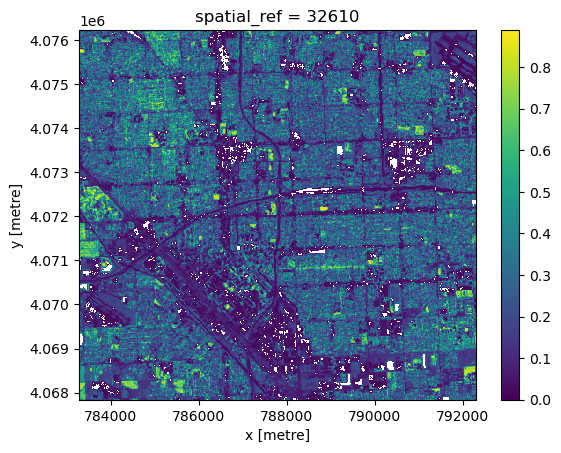

In [28]:
ndvi.plot.imshow()


In [30]:
import rioxarray

ndvi4326 = (
    ndvi
    .rio.write_crs("EPSG:32610", inplace=False)   # sentinel-2 native CRS
    .rio.reproject("EPSG:4326")                   # convert to lat/lon
)

ndvi4326.rio.to_raster(
    "fresno_ndvi.tif",
    driver="COG",
    compress="deflate"
)


In [34]:
# --- Zonal NDVI statistics for each HOLC polygon ---
fresno_stats = exact_extract(
    "fresno_ndvi.tif",
    fresno,
    ["mean"],
    include_geom=True,
    include_cols=["label", "grade", "city", "fill"],
    output="pandas"
).rename(columns={"mean": "zone_ndvi"})

fresno_stats.head()


,label,grade,city,fill,zone_ndvi,geometry
0,A1,A,Fresno,#76a865,0.412477,"MULTIPOLYGON (((-119.80871 36.77829, -119.8086..."
1,A2,A,Fresno,#76a865,0.406964,"MULTIPOLYGON (((-119.80451 36.76402, -119.8045..."
2,B1,B,Fresno,#7cb5bd,0.415784,"MULTIPOLYGON (((-119.79969 36.78518, -119.7996..."
3,B2,B,Fresno,#7cb5bd,0.317732,"MULTIPOLYGON (((-119.80111 36.77551, -119.8015..."
4,B3,B,Fresno,#7cb5bd,0.260128,"MULTIPOLYGON (((-119.74395 36.74304, -119.7436..."


In [32]:
fresno_avg = (
    fresno_stats.groupby("grade")["zone_ndvi"].mean().reset_index()
)
fresno_avg

,grade,zone_ndvi
0,A,0.409721
1,B,0.321582
2,C,0.241117
3,D,0.226329


In [33]:
fresno_range = (
    fresno_stats.groupby("grade")["zone_ndvi"]
    .agg(low_ndvi="min", high_ndvi="max")
    .reset_index()
)

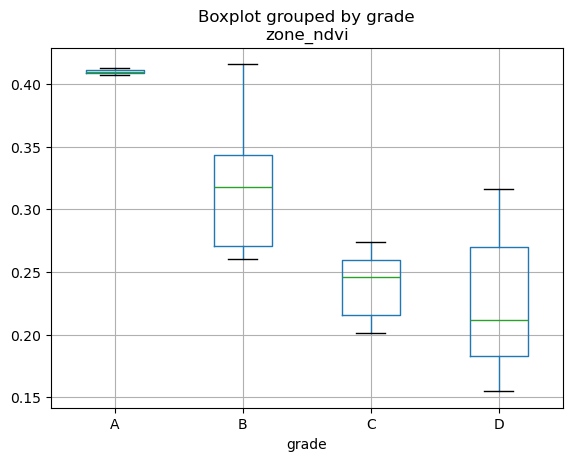

In [37]:

fresno_stats.boxplot(column="zone_ndvi", by="grade")

import os


if not os.path.exists("docs"):
    os.makedirs("docs")

